# Overview

In order to dataset code to be decoupled from the model training code for better readability and modularity. PyTorch provides two data primitives:

* torch.utils.data.DataLoader
* torch.utils.data.Dataset

These two that allow you to use pre-loaded datasets as well as our own data. **Dataset stores the samples and their corresponding labels**, and **DataLoader wraps an iterable around the Dataset to enable easy access to the samples**. And there are different types of PyTorch Datasets like:

* Image Datasets(torchvision)
* Text Datasets(torchtext)
* Audio Datasets(torchaudio)

<div style="text-align: center"><img src="https://files.mastodon.social/media_attachments/files/111/836/684/650/372/165/original/bea420ea27ad0737.png" width="90%" heigh="90%" alt="torch.utils.data"></div>

# Loading a Dataset

Let's use DataLoader to load the Fashion-MNIST dataset from `TorchVision`. Fashion-MNIST is a dataset of Zalando's article image consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28x28 grayscale image and an associated label from one of 10 classes.

We load the Dataset with the following parameters:
* `root` is the path where the train/test data is stored
* `train` specifies training ot test dataset
* `download=True` downloads the data from the internet if it's not avaliable at root
* `transform` and `target_transform` specify the feature and label transformations

In [1]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data=datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data=datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 13053461.74it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 205908.87it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3839446.44it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18957223.00it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



# Iterating and Visualizing the Dataset

We can index `Datasets` manually like a list: `training_data[index]`. We use `matplotlib` to visualize some samples in our training data.

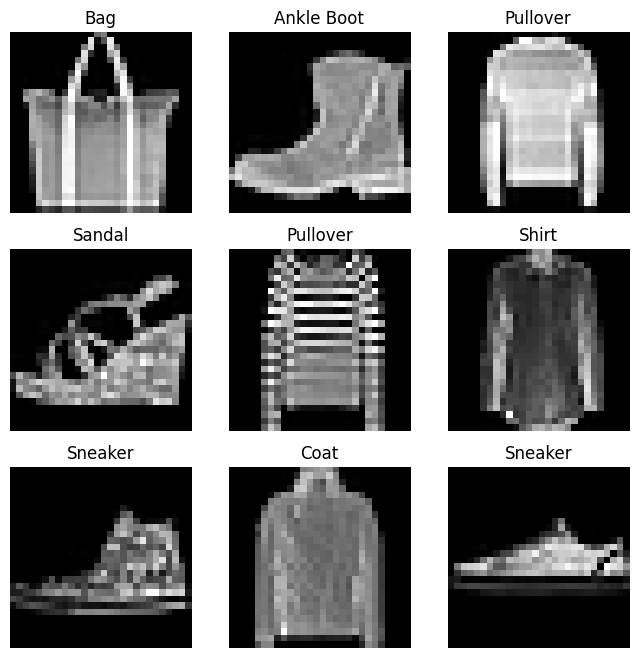

In [2]:
import torch
import matplotlib.pyplot as plt

labels_map={
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure=plt.figure(figsize=(8,8))
cols, rows=3,3
for i in range(1, cols*rows+1):
    sample_idx=torch.randint(len(training_data), size=(1,)).item()
    img, label=training_data[sample_idx]
    figure.add_subplot(rows, cols,i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Dataset Types

The most important argument of DataLoader constructor is dataset, which indicates a dataset object to load data from. PyTorch supports two different types of datasets:
* map-style datasets
* iterable-style datasets

## Map-style datasets

A map-style dataset is one that implements the `__getitem__()` and `__len()__()` protocols, and represents a map from(possibly non-integral) indices/keys to data samples.

For example, such a dataset, when accessed with `dataset[idx]`, could read the `idx`-th image and its corresponding label from a folder on the disk.

## Iterable-style datasets

An iterable-style dataset is an instance of a subclass of `IterableDataset` that implements the `__iter__()` protocol, and represents an iterable over data samples. This type of dataset is particularly suitable for cases where random reads are expensive or even improbable, and where the batch size depends on the fetched data.

For example, such a dataset, when called `iter(dataset)`, could return a stream of data reading from a database, a remote server, or even logs generated in real time. See below code snippet:

In [3]:
import torch

class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, start, end):
        super(MyIterableDataset).__init__()
        assert end> start, "only works with end>=start"
        
        self.start=start
        self.end=end
        
    def __iter__(self):
        worker_info=torch.utils.data.get_worker_info()
        if worker_info is None:
            iter_start=self.start
            iter_end=self.end
        else:
            per_worker=int(math.ceil((self.end-self.start)/float(worker_info.num_workers)))
            worker_id=worker_info.id
            iter_start=self.start+worker_id*per_worker
            iter_end=min(iter_start+per_worker, self.end)
        return iter(range(iter_start, iter_end))

ds=MyIterableDataset(start=3, end=7)

# Single-process loading
print(list(torch.utils.data.DataLoader(ds, num_workers=0)))

# NameError: name 'math' is not defined
# Worker 0 fetched [3, 4].  Worker 1 fetched [5, 6].
# print(list(torch.utils.data.DataLoader(ds, num_workers=2)))

[tensor([3]), tensor([4]), tensor([5]), tensor([6])]


# Preparing the data for training with DataLoaders

The `Dataset` retrieves our dataset's features and labels one sample at a time. While training a model, we typically want to pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's `multiprocessing` to speed up data retrieval. `DataLoader` is what you need.

In [4]:
from torch.utils.data import DataLoader

train_dataloader=DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader=DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader

We have load the dataset inot the DataLoader and can iterate through the datasets as needed. Each iteration below returns a batch of `train_features` and `train_labels`(containing `batch_size=64` features and labels respectively). Because we specified `shuffle=True`, after we iterate over all batches the data is shuffled.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


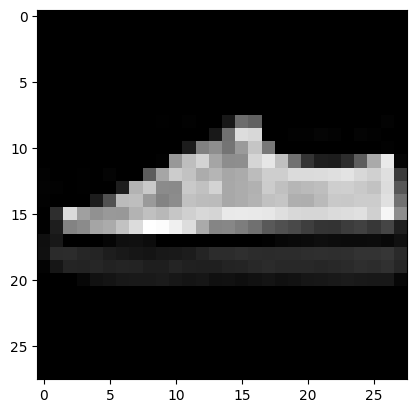

Label: 7


In [5]:
train_features, train_labels= next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img=train_features[0].squeeze()
label=train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Data Loading Order and Sampler

For iterable-style datasets, data loading order is entirely controlled by the user-define iterable. This allows easier implementations of chunk-reading and dynamic batch size(e.g., by yielding a batched sample at each time).

The rest of this section concerns the case with map-style datasets. `torch.utils.data.Sampler` classes are used to specify the sequence of indices/keys used in data loading. They represent iterable objects over the indices to datasets. E.g., in the common case with stochastic gradient decent(SGD), a Simpler could randomly permute a list of indices and yield each one at a time, or yield a small number of them for mini-batch SGD.

A sequential of shuffled sampler will be automatically constructed based on shuffle argument to a DataLoader. Alternatively, users may use the sampler argument to specify a custom Sampler could randomly permute a list of indices and yield each one at a time, or yield a small number of them for mini-batch SGD.

A sequantial or shuffled sampler wil be automatiaclly constructed based on the shuffle argument to a DataLoader. Alternatively, users may use the sampler argument to specify a custom Sampler object that at each time yields the next index/key to fetch.

A custom Sampler that yields a list of batch indices at a time can be passed as the batch_sampler argument. Automatic batching can also be enabled via batch_size and drop_last arguments.

**Note:**

Neither sampler nor batch_sampler is compatibel with iterable-style datasets, since such datasets have no notion of a key or an index.



# Automatic batching(default)

This is the most common case, and corresponds to fetching a minibatch of data and collating them into batched samples. i.e., containing Tensors with one dimension being the batch dimension(usually the first).

When `batch_size`(default 1) is not None, the data loader yields batched samples instead of individual samples. `batch_size` and `drop_last` arguments are used to specify how the data loader obtains batches of dataset keys. For map-style datasets, users can alternatively specify `batch_sampler`, which yields a list of keys at a time.

**Note:**

The `batch_size` and `drop_last` arguments essentially are used to construct a `batch_sampler` from `sampler`. For map-style datasets, the `sampler` is either provided by user of contructed based on the `shuffle` argument. For iterable-style datasets, the `sampler` is a dummy infinite one.

When fetching from `iterable-style datasets` with `multi-processing`, the `drop_last` argument drops the last non-full batch of each worker's dataset replica.

When both `batch_size` and `batch_sampler` are `None` (default value for `batch_sampler` is already `None`), automatic batching is disabled. Each sample obtained from the `dataset` is processed with the function passed as the `collate_fn` argument.

When automatic batching is diabled, the default `collate_fn` simply converts NumPY arrays into PyTorch Tensors, and keeps everything else untounched.